<a href="https://colab.research.google.com/github/BrunoGomesCoelho/mosquito-networking/blob/master/notebooks_tcc/1.7-BrunoGomesCoelho_Colab_fixes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab console code
"""
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect,60000)
"""

'\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument.querySelector("colab-toolbar-button#connect").click() \n}setInterval(ClickConnect,60000)\n'

## Check tensorflow version

In [2]:
#!python3 -m pip install --upgrade tensorflow-gpu -q

In [66]:
import tensorflow as tf
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
assert len(tf.config.experimental.list_physical_devices('GPU')) >= 1
assert tf.test.is_gpu_available()


TensorFlow version:  2.0.0
Num GPUs Available:  2


In [59]:
!export CUDA_VISIBLE_DEVICES=0,1

In [65]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [9]:
# Start logging time
import time
start_time = time.time()

In [10]:
COLAB_IDX = 1
TEMPERATURE = "t02"
FORMAT = "repeat"

In [11]:
SCALE = False
TESTING = True
COLAB = False

if COLAB:
    BASE_DIR = "/content/drive/My Drive/IC/mosquito-networking/"
else:
    BASE_DIR = "../"

In [12]:
if COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive', force_remount=True)

In [13]:
if COLAB:
    import sys
    sys.path.append("/content/drive/My Drive/IC/mosquito-networking/")

In [14]:
if COLAB:
    !python3 -m pip install -qr "/content/drive/My Drive/IC/mosquito-networking/drive_requirements.txt"

In [15]:
if not COLAB:
    # OPTIONAL: Load the "autoreload" extension so that code can change
    %load_ext autoreload
    # OPTIONAL: always reload modules so that as you change code in src, it gets loaded
    %autoreload 2

In [16]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Experiment params

In [17]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'epochs': 2 if TESTING else 100}

# load data

In [18]:
# Load scaler
#scaler = joblib.load("../data/interim/scaler.pkl")
if SCALE:
    scaler = joblib.load(BASE_DIR + 
                         f"data/interim/scaler_{FORMAT}_{TEMPERATURE}_no_std.pkl")

In [19]:
#data = np.load(BASE_DIR + f"data/interim/all_wavs_{FORMAT}_{TEMPERATURE}.npz",
data = np.load(BASE_DIR + f"data/interim/all_wavs_{FORMAT}_{TEMPERATURE}_no_std.npz",
               allow_pickle=True)

In [20]:
SCALE=False

In [21]:
# Parse and divide data
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]

if SCALE:
    x_train = scaler.transform(train_data[:, :-1])
    x_val = scaler.transform(val_data[:, :-1])
    x_test = scaler.transform(test_data[:, :-1])
else:
    x_train = train_data[:, :-1]
    x_val = val_data[:, :-1]
    x_test = test_data[:, :-1]

y_train = train_data[:, -1]
y_val = val_data[:, -1]
y_test = test_data[:, -1]

In [22]:
x_train = x_train / 32
x_val = x_val / 32
x_test = x_test / 32

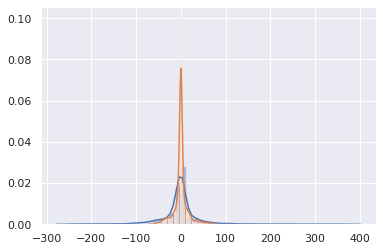

In [23]:
#sns.distplot(x_train[0])
sns.distplot(x_train[-1])
#sns.distplot(x_val[0])
sns.distplot(x_val[-1])

In [24]:
print("Train:", x_train.min(), f"\t {x_train.mean():.2f}", x_train.max())
print("Val:", x_val.min(), f"\t \t {x_val.mean():.2f}", x_val.max())
print("Test:", x_test.min(), f"\t {x_test.mean():.2f}", x_test.max())

Train: -774.71875 	 -0.02 1023.96875
Val: -762.25 	 	 -0.02 1023.96875
Test: -787.03125 	 -0.01 1023.96875


In [25]:
# Reshape data
x_train = x_train.reshape((*x_train.shape, 1))
x_val = x_val.reshape((*x_val.shape, 1))
x_test = x_test.reshape((*x_test.shape, 1))

In [26]:
# Generators
# I am not using generators since currently the dataset fits on RAM

# Load model

In [28]:
"""A much better way to load a custom module since it allows us to change it easierly
    on the fly. Idea from https://zerowithdot.com/colab-workspace/
"""
from os.path import join
from importlib.machinery import SourceFileLoader
wingbeats_model = SourceFileLoader('wingbeats_model', join(BASE_DIR, 'src/models/wingbeats_model.py')).load_module()
#model = wingbeats_model.WingbeatsNetModel(dropout=False)
#from src.models.wingbeats_model import WingbeatsNetModel
#model = WingbeatsNetModel(dropout=False)
# load weights?
#f"runs/colab/{COLAB_IDX-1}/model_epoch_90.pt"))
#model.summary() 

<br>
<br>
<br>
<br>
<br>
<br>

# Start tensorboard

In [29]:
save_path =  BASE_DIR + f"runs/TCC/{TEMPERATURE}/{FORMAT}/{COLAB_IDX}/"

In [30]:
#!python3 -m pip install --upgrade -q grpcio

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [77]:
!kill 21091
%tensorboard --logdir logs

/bin/sh: 1: kill: No such process



<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# train function

In [67]:
MODEL = "testing"
model_name = f"{MODEL}"

In [68]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau, CSVLogger,
                                        TensorBoard)

In [69]:
# Overfit small amount of data
temp = x_train.copy()
temp_y = y_train.copy()

In [36]:
#x_train = x_train[:10]
#_train = y_train[:10]

In [108]:
params["epochs"] = 10
params["batch_size"] = 64

model = wingbeats_model.WingbeatsNetModel(dropout=True, batch_norm=True, 
                                          use_noise=True, blocks=5,
                                          noise_std=0.1)#lr=0.0001)
model.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 11025, 1)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 11023, 16)         64        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 11021, 16)         784       
_________________________________________________________________
batch_normalization_8 (Batch (None, 11021, 16)         64        
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 11019, 32)         1568      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 11017, 32)         3104      
__________________________________

In [109]:
from datetime import datetime


top_weights_path = 'model_' + model_name + '.h5'

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, write_grads=True,
                                   write_graph=True, write_images=True,
                                   histogram_freq=1)

callbacks_list = [
    #ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1,
    #                save_best_only=True, save_weights_only=True),
    #EarlyStopping(monitor='val_accuracy', patience=6, verbose=1),
    tensorboard_callback]#,
    #ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.1, 
    #                  patience=3, verbose=1),
    #CSVLogger('model_' + model_name + '.log')]

histories = model.fit(x_train, y_train,
                      validation_split=0.2,
                      callbacks=callbacks_list,
                      **params)

Train on 2377 samples, validate on 595 samples
Epoch 1/10
2377/2377 [==============================] - 17s 7ms/sample - loss: 0.6648 - accuracy: 0.5886 - val_loss: 0.9740 - val_accuracy: 0.4908
Epoch 2/10
2377/2377 [==============================] - 14s 6ms/sample - loss: 0.4435 - accuracy: 0.8077 - val_loss: 0.9653 - val_accuracy: 0.5126
Epoch 3/10
2377/2377 [==============================] - 14s 6ms/sample - loss: 0.2954 - accuracy: 0.9062 - val_loss: 1.1370 - val_accuracy: 0.5176
Epoch 4/10
2377/2377 [==============================] - 14s 6ms/sample - loss: 0.2197 - accuracy: 0.9382 - val_loss: 1.7222 - val_accuracy: 0.5126
Epoch 5/10
2377/2377 [==============================] - 14s 6ms/sample - loss: 0.1672 - accuracy: 0.9584 - val_loss: 2.5203 - val_accuracy: 0.5126
Epoch 6/10
2377/2377 [==============================] - 14s 6ms/sample - loss: 0.1433 - accuracy: 0.9655 - val_loss: 1.2760 - val_accuracy: 0.5143
Epoch 7/10
2377/2377 [==============================] - 14s 6ms/sample 

KeyboardInterrupt: 

In [ ]:
def check_grad_proportion(model, x_train, layer_idx=1, amount=100):
    name = model.get_config()["layers"][layer_idx]["config"]["name"]
    inputs = tf.cast(x_train[:amount], tf.float32)

    with tf.GradientTape() as tape:
        preds = model(inputs)

    grads = tape.gradient(preds, model.get_layer(name).trainable_variables)
    weights =  model.get_layer(name).weights
    proportion = grads[0] / weights[0]
    proportion_avg = tf.math.reduce_mean(proportion)
    print(f"Average proportion between grad and weights: {proportion_avg}")
    print(f"Some proportions:")
    print(proportion[:5])
    return grads, weights


In [ ]:
grads, weights = check_grad_proportion(model, x_train)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
for test_x, test_y, name in [(x_val, y_val, "val"), 
                             (x_test, y_test, "test")]:
    print(f"For {name}, the results are:")
    preds = model.predict(test_x).round()
    print(classification_report(test_y, preds))
    print(f"And total acc is {accuracy_score(test_y, preds)}")
    print("\n\n")